Follows from [single_exposure_modeling_wcupy_realdata](single_exposure_modeling_wcupy_realdata.ipynb).  

Goal is to checking some of the weird pixels' ramps.  First we need the uncal for the test exposure though, so this begins by getting that.

Note since these data were taken in ${\rm IRS}^2$ mode, the data are not simple pixel patterns - 
https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-instrumentation/nirspec-detectors/nirspec-detector-readout-modes-and-patterns/nirspec-irs2-detector-readout-mode is invaluable for understanding the uncal format.

In [1]:
import os
from collections import defaultdict
from pathlib import Path
from getpass import getpass

import numpy as np

from astropy import table
from astropy import units as u
from astropy.io import fits


from jwst import datamodels

from astroquery.mast import Observations

In [2]:
%matplotlib inline

from astropy import visualization
visualization.quantity_support()
from matplotlib import pyplot as plt

In [3]:
Observations.login('f47d754946434169a591ee36b6a40f1f')

INFO: MAST API token accepted, welcome Erik Tollerud [astroquery.mast.auth]


In [4]:
obses = Observations.query_criteria(proposal_id=2609, obs_collection='JWST')
prods = Observations.get_product_list(obses)
matching = prods[np.array(['jw02609009001_04101_00001_nrs2' in row['productFilename'] for row in prods])]

In [5]:
ufilenames = np.unique(matching['productFilename'])
uncal = [fn for fn in ufilenames if 'uncal.fits' in fn]
assert len(uncal) == 1
uncalfn = uncal[0]

todl = matching[uncalfn==matching['productFilename']][:1]
result = Observations.download_products(todl)
uncal_dm = datamodels.open(result['Local Path'][0])

INFO: Found cached file ./mastDownload/JWST/jw02609009001_04101_00001_nrs2/jw02609009001_04101_00001_nrs2_uncal.fits with expected size 524341440. [astroquery.query]


And grab the rateint in case we need it.  Should already be there from the bulk download.

In [6]:
ratei_dm = datamodels.open(result['Local Path'][0].replace('_uncal', '_rateints'))

In [7]:
uncal_dm.shape

(2, 20, 3200, 2048)

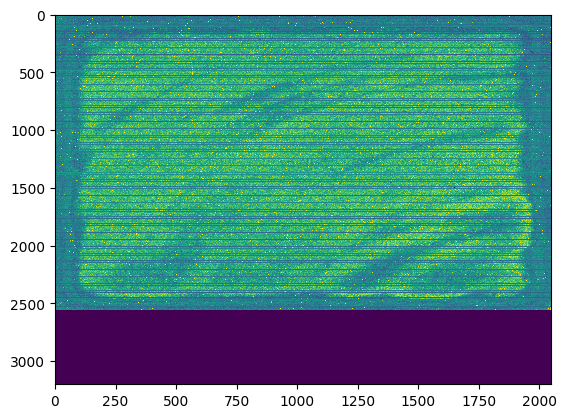

In [137]:
single_plane = uncal_dm.data[0,10]

fig, ax = plt.subplots(1,1)
visualization.imshow_norm(single_plane, aspect='auto',
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LinearStretch(),
                          interpolation='nearest', ax=ax);

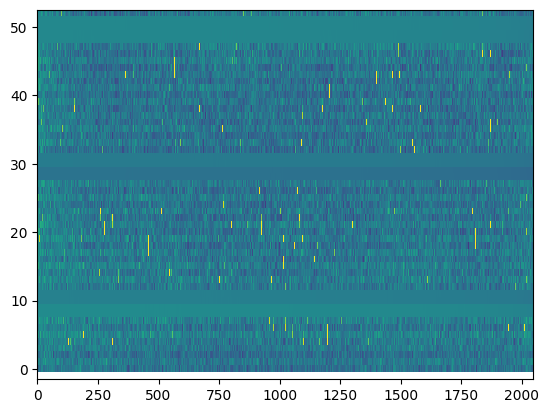

In [9]:
ax.set_ylim(-1.5, 8*6+4.5)
fig

So the pattern is 8data,4ref,8data xN, where 

In [10]:
pix_per_detector = 2048*((8+8+4)/(8+8))
pix_per_detector

2560.0

And the reference group is at the *end*, and is as big as the 4 science groups:

In [11]:
assert pix_per_detector * 5/4 == single_plane.shape[0]

So then make a mask to pick out just the science rows:

In [12]:
onegrp = np.arange(8+4+8)
onescimask = (onegrp < 8) | (onegrp > 11)
onescimask

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True])

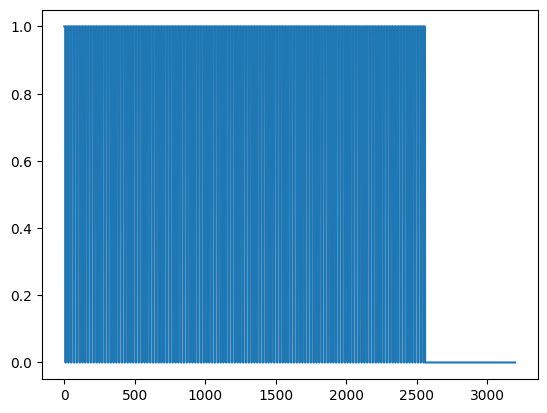

In [13]:
scimask = np.tile(onescimask, int(pix_per_detector)//len(onescimask))
scimask = np.concatenate([scimask, np.zeros(single_plane.shape[0]-len(scimask), dtype=bool)])
plt.plot(scimask);

In [134]:
single_plane_scipix = single_plane[scimask]
assert single_plane_scipix.shape == (2048, 2048)

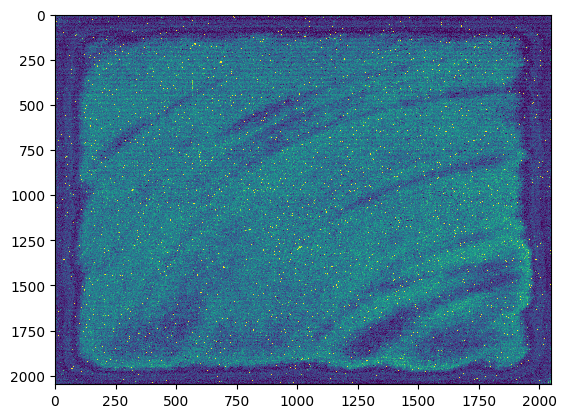

In [15]:
fig, ax = plt.subplots(1,1)
visualization.imshow_norm(single_plane_scipix, aspect='auto',
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LinearStretch(),
                          interpolation='nearest', ax=ax);

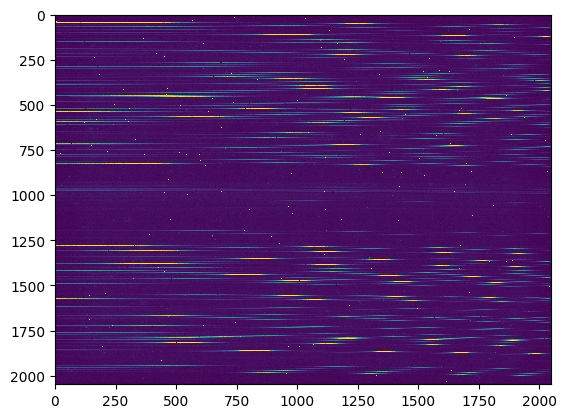

In [16]:
visualization.imshow_norm(ratei_dm.data[0], aspect='auto',
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LinearStretch(),
                          interpolation='nearest');

Try to pick out a specific slit.

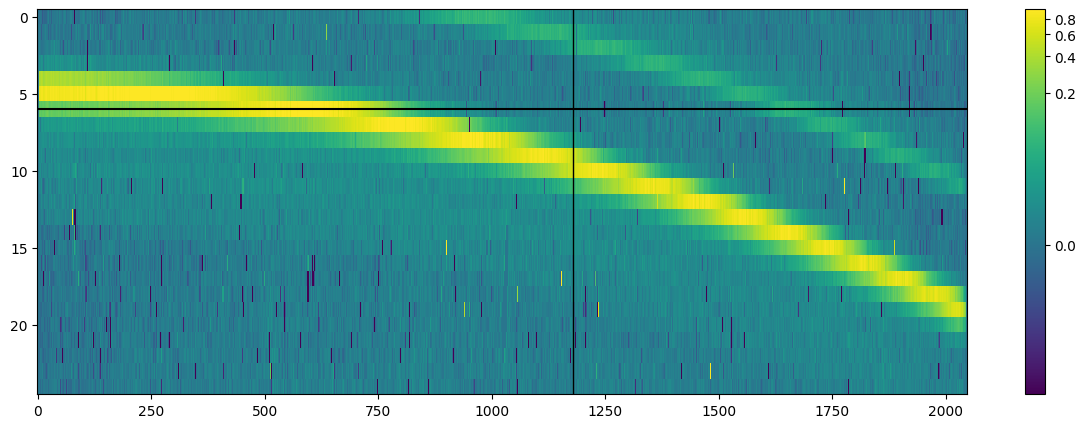

In [186]:
subrate = ratei_dm.data[0, 105:130]

plt.figure(figsize=(15, 5))
visualization.imshow_norm(subrate, aspect='auto',
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LogStretch(),
                          interpolation='nearest')
plt.colorbar()
subrate.shape
plt.axhline(6,c='k')
plt.axvline(1180,c='k', lw=1)

In [95]:
yg, xg = np.mgrid[:subrate.shape[0], :subrate.shape[1]]
msk = subrate > 1
[(xi, yi) for xi, yi in zip(xg[msk], yg[msk]) if yi==15]

[(77, 15), (393, 15), (517, 15), (900, 15), (1522, 15)]

In [103]:
subrate[15, 900]

2.231055

In [111]:
masked_uncal_data = uncal_dm.data[:,:, scimask, :]

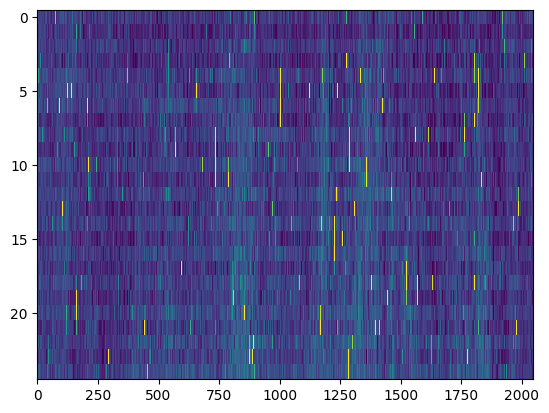

In [117]:
visualization.imshow_norm(masked_uncal_data[1,19][105:130], aspect='auto',
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LinearStretch(),
                          interpolation='nearest');

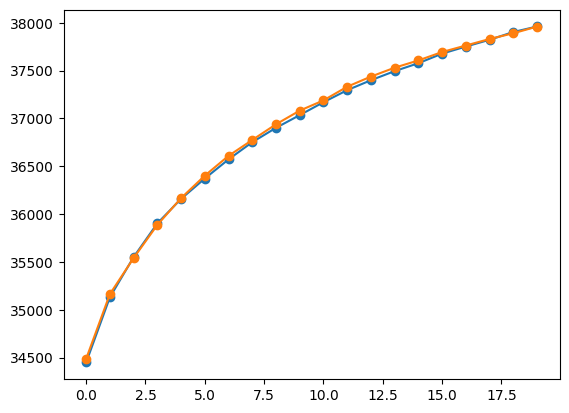

In [130]:
plt.plot(masked_uncal_data[0,:,105:130,:][:, 15, 900],'o-')
plt.plot(masked_uncal_data[1,:,105:130,:][:, 15, 900],'o-')

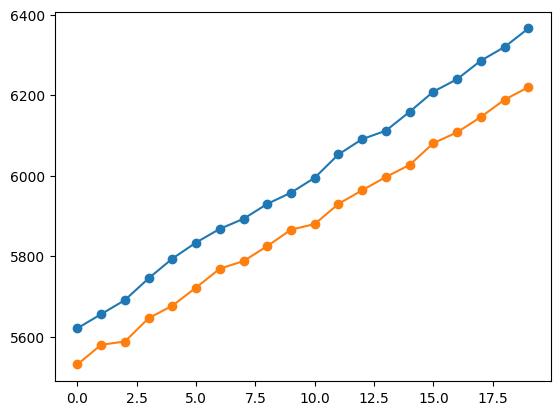

In [131]:
plt.plot(masked_uncal_data[0,:,105:130,:][:, 15, 1750],'o-')
plt.plot(masked_uncal_data[1,:,105:130,:][:, 15, 1750],'o-')

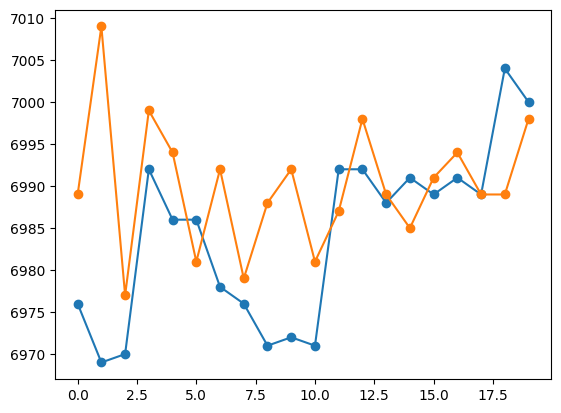

In [132]:
plt.plot(masked_uncal_data[0,:,105:130,:][:, 15, 200],'o-')
plt.plot(masked_uncal_data[1,:,105:130,:][:, 15, 200],'o-')

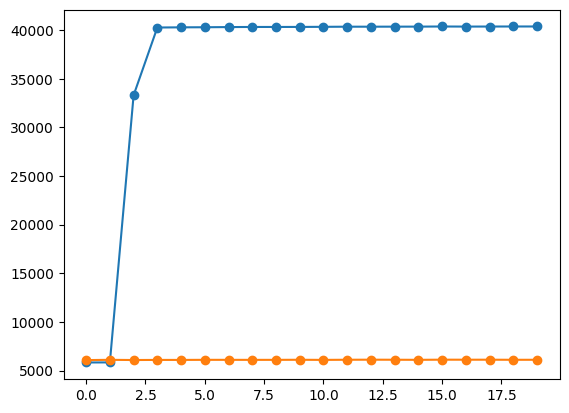

In [196]:
plt.plot(masked_uncal_data[0,:,105:130,:][:, 6, 1179],'o-')
plt.plot(masked_uncal_data[1,:,105:130,:][:, 6, 1179],'o-')

CR presumably?

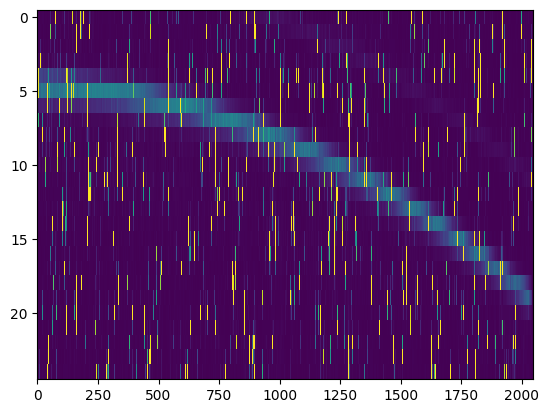

In [146]:
visualization.imshow_norm(masked_uncal_data[1,19][105:130].astype(int)-masked_uncal_data[1,0][105:130].astype(int), aspect='auto',
                          interval=visualization.PercentileInterval(95),
                          stretch=visualization.LinearStretch(),
                          interpolation='nearest');

In [ ]:
plt.plot(masked_uncal_data[0,:,105:130,:][:, 15, 200],'o-')
plt.plot(masked_uncal_data[1,:,105:130,:][:, 15, 200],'o-')